In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from src.data import data_layer
from src.model.model_utils import calculateStatistics
from src.model.model_GAN import FeedForwardModelWithNA_GAN_Ensembled
from src.model.model_RtnFcst import FeedForwardModelWithNA_Return_Ensembled
from src.utils import deco_print
from src.utils import load_dataframe
from src.utils import sharpe
from src.utils import max_1_month_loss
from src.utils import max_drawdown
from src.utils import eval_RtnFcst
from src.utils import construct_decile_portfolios
from src.utils import plot_decile_portfolios
from src.utils import plot_SMV
from src.utils import plot_SDF
from src.utils import plotReturnDecile
from src.utils import OLS
from src.utils import GRS
from src.utils import calculateStatisticsDecile
from src.utils import calculateStatisticsDoubleSorted5
from src.utils import calculateTurnover_with_dl

C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorf

In [2]:
print(tf.__version__)

1.12.0


Note that the newest version of matplotlib may have some bug in plotting Contour Slice plots, and we used 3.1.3 version for the plots

In [3]:
print(matplotlib.__version__)

3.1.3


Below is a sample of the first step training for the main SDF network for a single run of one set of hyperparameters. This roughly takes 4 hours on my Intel i9 CPU ( and takes less than 3 hours on a Nvidia Titan V GPU with the CUDA version of Tensorflow).

As specified in Table A.I of the paper, we ran search on 384 sets of hyper-parameters (labeled by task_id). Then for the top candidates we further ran 8 more trials for ensemble results (labelled by trial_id).

For easier replication, we have provided 9 trials of sample checkpoints with the hyperparameter sets we used in the paper. These sample checkpoints are newly trained and are different from the ones we used to generate the results in the paper. Due to the randomness from Tensorflow model weights initialization, it is expected that the metrics and not 100% identical from run to run. But from our tests the differences are reasonably small. As an example, in table 1 we reported 0.75 testing Sharpe ratio for the GAN model, but this sample checkpoints give 0.77. These small differences are within margin of error and do not change the conclusions we draw in the paper.

In [3]:
# !python run.py --config=config/config.json --logdir=output --saveBestFreq=128 --printOnConsole=True --saveLog=True --ignoreEpoch=32  --task_id 1 --trial_id 0

>==================> Read the following in config: 
{
    "learning_rate": 0.001,
    "num_layers_moment": 0,
    "num_units_rnn": [
        4
    ],
    "macro_feature_file_test": "datasets/macro/macro_test.npz",
    "optimizer": "Adam",
    "macro_feature_file": "datasets/macro/macro_train.npz",
    "use_rnn": true,
    "weighted_loss": true,
    "hidden_dim": [
        64,
        64
    ],
    "cell_type_rnn_moment": "lstm",
    "cell_type_rnn": "lstm",
    "macro_feature_file_valid": "datasets/macro/macro_valid.npz",
    "num_epochs_moment": 64,
    "tSize_test": 300,


2022-12-21 08:46:21.887227: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file output\RF_1_Trial_0 already exists.
Error occurred while processing: output\RF_1_Trial_0.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
2022-12-21 08:47:21.443302: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:666] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-21 08:47:22.405247: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:666] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-21 08:47:24.799947: E tensorflow/core/grappler/optimizers/dependency_o

    "tSize": 240,
    "individual_feature_dim": 46,
    "tSize_valid": 60,
    "num_condition_moment": 8,
    "loss_factor": 1.0,
    "num_layers_rnn_moment": 1,
    "individual_feature_file_valid": "datasets/char/Char_valid.npz",
    "num_epochs": 1024,
    "individual_feature_file": "datasets/char/Char_train.npz",
    "num_units_rnn_moment": [
        32
    ],
    "num_epochs_unc": 256,
    "dropout": 0.95,
    "macro_feature_dim": 178,
    "num_layers_rnn": 1,
    "sub_epoch": 4,
    "individual_feature_file_test": "datasets/char/Char_test.npz",
    "hidden_dim_moment": [],
    "num_layers": 2,
    "macro_idx": null
}
>==================> Creating data layer
>==================> Data layer created
>==================> Trainable variables (scope=Model_Layer)
Name: Model_Layer/RNN_Layer/rnn/lstm_cell/kernel:0 and shape: (182, 16)
Name: Model_Layer/RNN_Layer/rnn/lstm_cell/bias:0 and shape: (16,)
Name: Model_Layer/NN_Layer/dense_layer_0/dense/kernel:0 and shape: (50, 64)
Name: Model_La


'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
2022-12-21 10:23:28.926101: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:666] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-21 10:23:29.440100: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:666] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-21 10:23:30.630666: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:666] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-21 10:23:30.756235: E tensorflow/core/grap

>==================> Number of parameters: 10417
>==================> Trainable variables (scope=Moment_Layer)
Name: Moment_Layer/RNN_Layer/rnn/lstm_cell/kernel:0 and shape: (210, 128)
Name: Moment_Layer/RNN_Layer/rnn/lstm_cell/bias:0 and shape: (128,)
Name: Moment_Layer/NN_Layer/last_dense_layer/dense/kernel:0 and shape: (78, 8)
Name: Moment_Layer/NN_Layer/last_dense_layer/dense/bias:0 and shape: (8,)
>==================> Number of parameters: 27640
>==================> Trainable variables (scope=Model_Layer)
Name: Model_Layer/RNN_Layer/rnn/lstm_cell/kernel:0 and shape: (182, 16)
Name: Model_Layer/RNN_Layer/rnn/lstm_cell/bias:0 and shape: (16,)
Name: Model_Layer/NN_Layer/dense_layer_0/dense/kernel:0 and shape: (50, 64)
Name: Model_Layer/NN_Layer/dense_layer_0/dense/bias:0 and shape: (64,)
Name: Model_Layer/NN_Layer/dense_layer_1/dense/kernel:0 and shape: (64, 64)
Name: Model_Layer/NN_Layer/dense_layer_1/dense/bias:0 and shape: (64,)
Name: Model_Layer/NN_Layer/last_dense_layer/dense/ke

A subdirectory or file -p already exists.
Error occurred while processing: -p.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or extern

##### Model Configurations

In [4]:
task_id = 1
logdir = 'sample_checkpoints'
logdirs = [logdir + '/Task_%d_Trial_%d/sharpe' %(task_id, k) for k in range(9)]
with open('config/config.json') as file:
    config = json.load(file)

##### Load Data

In [5]:
dl = data_layer.DataInRamInputLayer(config['individual_feature_file'],
                                    pathMacroFeature=config['macro_feature_file'])
meanMacroFeature, stdMacroFeature = dl.getMacroFeatureMeanStd()
dl_valid = data_layer.DataInRamInputLayer(config['individual_feature_file_valid'],
                                          pathMacroFeature=config['macro_feature_file_valid'],
                                          meanMacroFeature=meanMacroFeature,
                                          stdMacroFeature=stdMacroFeature)
dl_test = data_layer.DataInRamInputLayer(config['individual_feature_file_test'],
                                         pathMacroFeature=config['macro_feature_file_test'],
                                         meanMacroFeature=meanMacroFeature,
                                         stdMacroFeature=stdMacroFeature)

##### Load Model

In [6]:
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize'], global_step=global_step)
model_valid = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize_valid'], force_var_reuse=True, global_step=global_step)
model_test = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize_test'], force_var_reuse=True, global_step=global_step)
model_plot = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'plot', 1, force_var_reuse=True, global_step=global_step)
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

In [7]:
INITIAL_train = model.getZeroInitialState()
INITIAL_valid = model.getNextInitialState(sess, dl, initial_state=INITIAL_train)
INITIAL_test = model_valid.getNextInitialState(sess, dl_valid, initial_state=INITIAL_valid)

INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_5/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_6/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkp

##### Model Performance

In [8]:
w = model.getWeightWithData(sess, dl, initial_state=INITIAL_train, normalized=True)
w_valid = model_valid.getWeightWithData(sess, dl_valid, initial_state=INITIAL_valid, normalized=True)
w_test = model_test.getWeightWithData(sess, dl_test, initial_state=INITIAL_test, normalized=True)

INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_5/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_6/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkp

In [9]:
Ftrain = model.getNormalizedSDFFactor(sess, dl, initial_state=INITIAL_train)
Fvalid = model_valid.getNormalizedSDFFactor(sess, dl_valid, initial_state=INITIAL_valid)
Ftest = model_test.getNormalizedSDFFactor(sess, dl_test, initial_state=INITIAL_test)
sdf_norm_ensemble = np.concatenate([Ftrain, Fvalid, Ftest])
np.save(os.path.join(logdir, 'sdf_normalized_ensemble.npy'), sdf_norm_ensemble)

INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_5/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_6/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkp

Sharpe ratio results for GAN reported in Table I

In [10]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))

>==================> SDF Portfolio Sharpe Ratio: Train 3.02	Valid 1.39	Test 0.77


### Variable Importance ### 
Figure 11

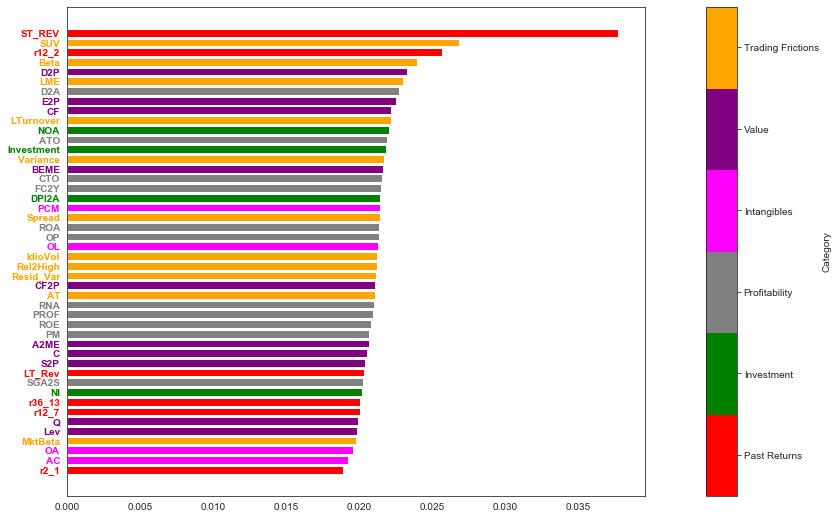

In [11]:
model_test.plotIndividualFeatureImportance(sess, dl_test, plotPath='plot', initial_state=INITIAL_test, top=46, figsize=(12,9))

Figure A.2

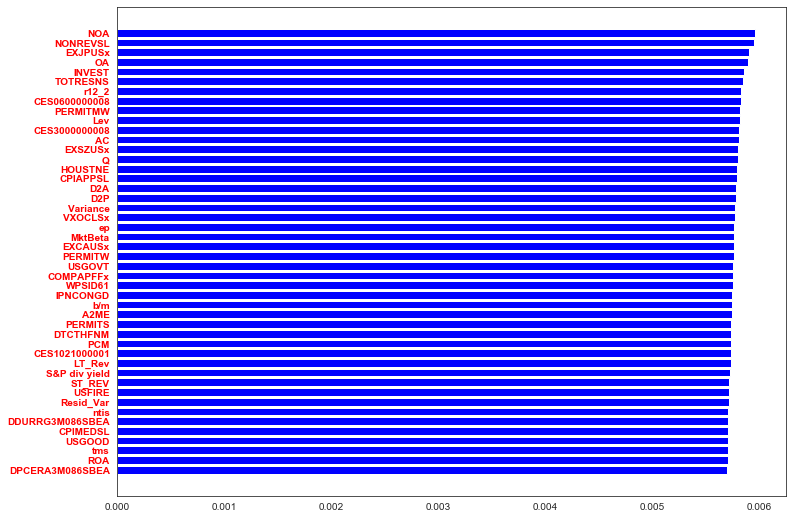

In [12]:
model_test.plotMacroFeatureImportance(sess, dl_test, plotPath='plot', initial_state=INITIAL_test, top=46, figsize=(12,9))

Figure 14

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 32
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_ch

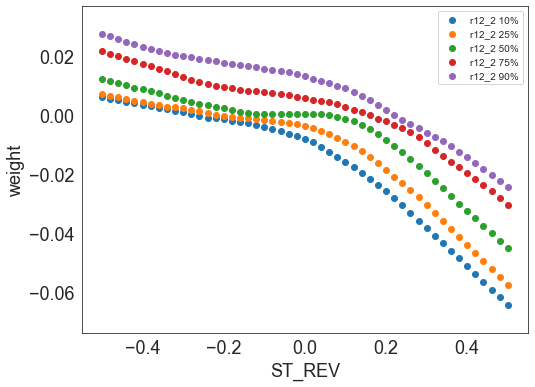

In [18]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 32
Enter variable idx for y (0 - 45, 46 - 223): 43
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_ch

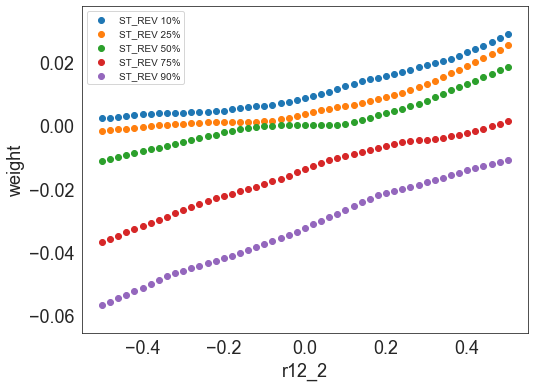

In [21]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 4
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_che

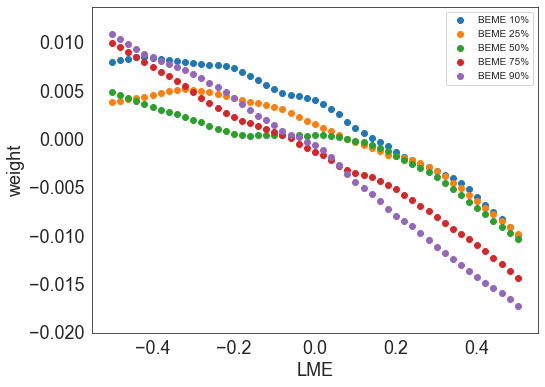

In [19]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 4
Enter variable idx for x (0 - 45, 46 - 223): 4
Enter variable idx for y (0 - 45, 46 - 223): 18
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_che

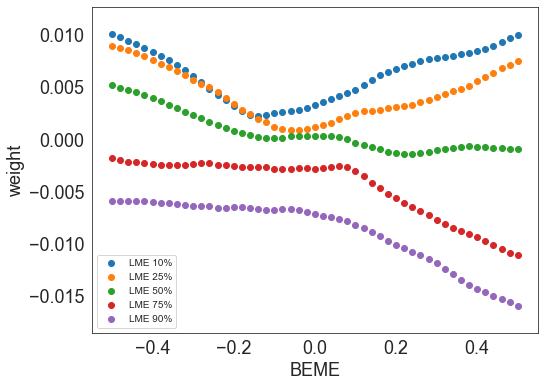

In [20]:
model_plot.plotWeight(sess, dl_test)

Figure 15

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 2
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 32
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_ch

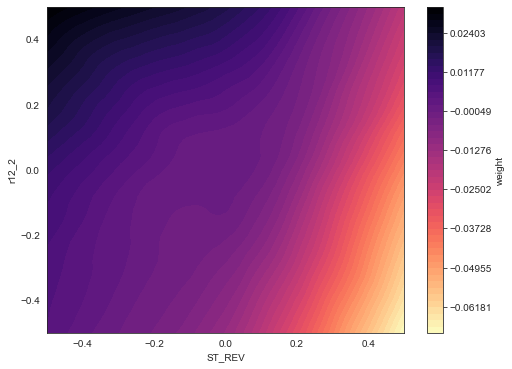

In [41]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 2
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 4
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_che

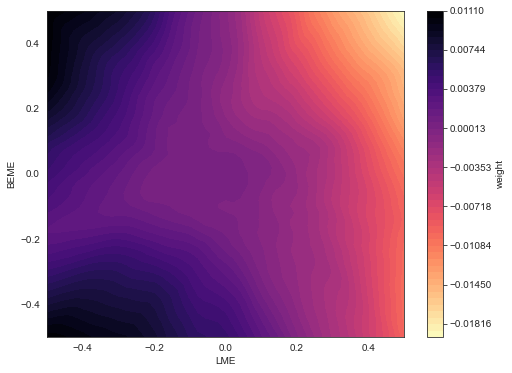

In [13]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 32
Enter variable idx for z (0 - 45, 46 - 223): 44
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INF

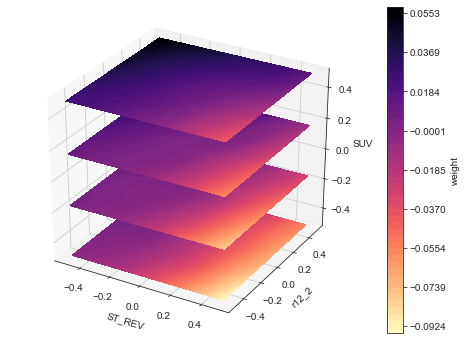

In [12]:
model_plot.plotWeight(sess, dl_test)

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 4
Enter variable idx for z (0 - 45, 46 - 223): 43
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_0/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_1/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_2/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_3/sharpe\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints/Task_1_Trial_4/sharpe\model-best
>==================> Restored checkpoint
INFO

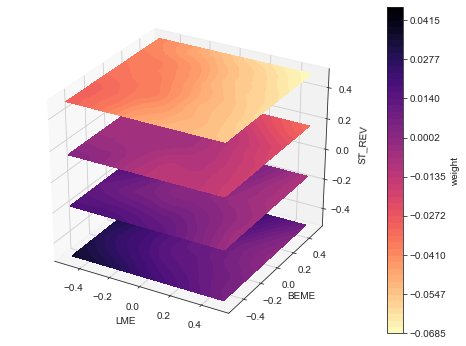

In [10]:
model_plot.plotWeight(sess, dl_test)

Figure 6

In [31]:
models = ['GAN (hidden state)', 'UNC', 'GAN (no macro)', 'FFN (no macro)', 'EN (no macro)', 'LS (no macro)', 'GAN (all macro)', 'FFN (all macro)', 'EN (all macro)', 'LS (all macro)']
SR = [[2.68, 1.43, 0.75],
     [1.93, 1.33, 0.53],
     [1.90, 1.35, 0.69],
     [0.45, 0.42, 0.44],
     [1.37, 1.15, 0.50],
     [1.80, 0.58, 0.42],
     [1.07, 0.05, 0.05],
     [1.46, 0.46, 0.21],
     [1.95, 0.54, 0.19],
     [2.63, 0.34, 0.10]]
df_SR = pd.DataFrame(SR, columns=['Training', 'Validation', 'Test'], index=models)
color_models = ['brown'] + ['red'] + ['orange'] * 4 + ['yellow'] * 4

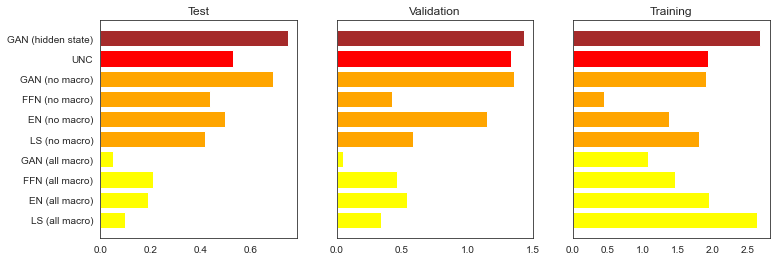

In [32]:
y_pos = np.arange(len(models))
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(131)
ax1.barh(y_pos, df_SR.loc[:,'Test'].values, align='center', color=color_models)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(models)
ax1.invert_yaxis()
ax1.set_title('Test')

ax2 = plt.subplot(132)
ax2.barh(y_pos, df_SR.loc[:,'Validation'].values, align='center', color=color_models)
ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_title('Validation')

ax3 = plt.subplot(133)
ax3.barh(y_pos, df_SR.loc[:,'Training'].values, align='center', color=color_models)
ax3.invert_yaxis()
ax3.set_yticks([])
ax3.set_title('Training')
plt.show()

##### Beta Model Network

If you have completely trained a new set of checkpoints, you can use them to re-train the Beta Preidctive Model network, which involves re-generate R*F data and model training

In [30]:
# !python create_RF_data.py

In [4]:
# !python run_RtnFcst_ensembles.py --config config_RF --logdir output_RF --task_id 1 --trial_id 0

>==================> Read the following in config: 
{
    "individual_feature_file": "datasets/RF/RF_train_normalized_task_1.npz",
    "individual_feature_file_valid": "datasets/RF/RF_valid_normalized_task_1.npz",
    "individual_feature_file_test": "datasets/RF/RF_test_normalized_task_1.npz",
    "macro_feature_file": "datasets/macro/macro_train.npz",
    "macro_feature_file_valid": "datasets/macro/macro_valid.npz",
    "macro_feature_file_test": "datasets/macro/macro_test.npz",
    "sub_epoch": false,
    "macro_idx": [],
    "macro_feature_dim": 0,
    "individual_feature_dim": 46,
    "num_layers": 3,
    "hidden_dim": [
        32,
        16,
        8
    ],
    "dropout": 0.95,
    "mode": "train",
    "num_epochs": 2048,
    "loss_factor": 1.0,
    "weighted_loss": false,
    "optimizer": "Adam",
    "learning_rate": 0.001
}
>==================> Creating data layer
>==================> Data layer created
>==================> Trainable variables (scope=Model_Layer)
Name: Model_

2022-12-21 23:21:57.234819: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file output_RF\RF_1_Trial_0 already exists.
Error occurred while processing: output_RF\RF_1_Trial_0.
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jason\anaconda3\envs\dlap-cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Us

>==================> Epoch 896 Elapse/Estimate: 1900.25s/4338.58s



>==================> Doing epoch 1024
>==================> Epoch 1024 train/valid/test loss: 0.0170/0.0116/0.0237
>==================> Epoch 1024 train/valid/test sharpe: 0.8455/0.8004/0.4702
>==================> Epoch 1024 Elapse/Estimate: 2159.50s/4314.79s



>==================> Doing epoch 1152
>==================> Epoch 1152 train/valid/test loss: 0.0170/0.0116/0.0237
>==================> Epoch 1152 train/valid/test sharpe: 0.8464/0.7519/0.4825
>==================> Epoch 1152 Elapse/Estimate: 2418.69s/4296.16s



>==================> Doing epoch 1280
>==================> Epoch 1280 train/valid/test loss: 0.0169/0.0116/0.0237
>==================> Epoch 1280 train/valid/test sharpe: 0.8791/0.7742/0.4834
>==================> Epoch 1280 Elapse/Estimate: 2677.88s/4281.27s



>==================> Doing epoch 1408
>==================> Epoch 1408 train/valid/test loss: 0.0169/0.0116/0.0237
>==================> Epoch 1408

##### Predictive Performance

In [13]:
logdirs_RF = ['sample_checkpoints_RF/RF_%d_Trial_%d' %(task_id, k) for k in range(9)]
with open('config_RF/config_RF_%d.json'%(task_id)) as file:
    config_RF = json.load(file)

In [14]:
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model_plot_RF = FeedForwardModelWithNA_Return_Ensembled(logdirs_RF, config_RF, 'plot', global_step=global_step)
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

In [15]:
dl_RF_train = data_layer.DataInRamInputLayer(config['individual_feature_file'])
dl_RF_valid = data_layer.DataInRamInputLayer(config['individual_feature_file_valid'])
dl_RF_test = data_layer.DataInRamInputLayer(config['individual_feature_file_test'])

In [16]:
beta_train = model_plot_RF.getPrediction(sess, dl_RF_train)
beta_valid = model_plot_RF.getPrediction(sess, dl_RF_valid)
beta_test = model_plot_RF.getPrediction(sess, dl_RF_test)

INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_0\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_1\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_2\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_3\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_4\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_5\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_6\model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from sample_checkpoints_RF/RF_1_Trial_7\model-best
>========

In [17]:
# EV, XS-R2
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test)

GAN network EV and XS-R2 results reported in Table 1. The numbers are slightly different from the checkpoints used in the paper but numbers are very similar.

In [18]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.19	Valid 0.09	Test 0.07
>==================> (Weighted) XS-R2: Train 0.12	Valid 0.01	Test 0.22


In [19]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(beta_train, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(beta_valid, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(beta_test, R, mask, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])

Figure 7

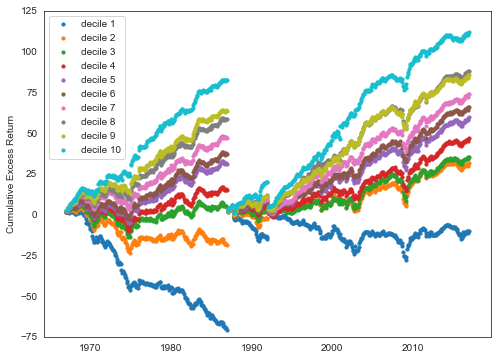

In [20]:
plot_decile_portfolios(df)

Figure 10

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.24s / 56.98s
>==================> Plotting Variable: AC	Elapse / Estimate: 2.47s / 56.87s
>==================> Plotting Variable: AT	Elapse / Estimate: 3.70s / 56.70s
>==================> Plotting Variable: ATO	Elapse / Estimate: 4.95s / 56.93s
>==================> Plotting Variable: BEME	Elapse / Estimate: 6.19s / 56.97s
>==================> Plotting Variable: Beta	Elapse / Estimate: 7.44s / 57.03s
>==================> Plotting Variable: C	Elapse / Estimate: 8.69s / 57.10s
>==================> Plotting Variable: CF	Elapse / Estimate: 9.92s / 57.05s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 11.17s / 57.07s
>==================> Plotting Variable: CTO	Elapse / Estimate: 12.40s / 57.05s
>==================> Plotting Variable: D2A	Elapse / Estimate: 13.63s / 56.99s
>==================> Plotting Variable: D2P	Elapse / Estimate: 14.84s / 56.89s
>==================> Plotting Variable: DPI2A	Elapse / Estima

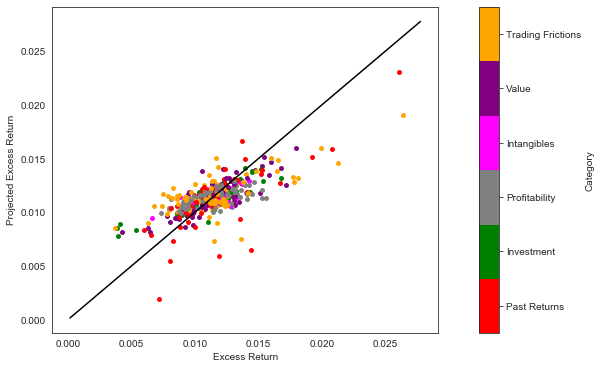

In [21]:
plotReturnDecile(dl_test, beta_test)